# Where to find referenced equations: 

[1] H. Owhadi and G. R. Yoo. Kernel flows: From learning kernels from data into the abyss. *Journal of Computational Physics*, 389:22–47, 2019. <br>
[2] B. Hamzi and H. Owhadi. Learning dynamical systems from data: a simple cross-validation perspective. *CoRR, abs/2007.05074* 2020.<br>
[3] F. Hoffmann, B. Hosseini, Z. Ren, and A. Stuart. Consistency of semi-supervised learning algorithms on graphs: Probit and one-hot methods. *Journal of Machine Learning Research 21*, 1-55, 2019

# Functions needed to compute u*

In [32]:
#!/usr/bin/env python
# coding: utf-8

# # Where to find referenced equations:

# [1] H. Owhadi and G. R. Yoo. Kernel flows: From learning kernels from data into the abyss. *Journal of Computational Physics*, 389:22–47, 2019. <br>
# [2] B. Hamzi and H. Owhadi. Learning dynamical systems from data: a simple cross-validation perspective. *CoRR, abs/2007.05074* 2020.<br>
# [3] F. Hoffmann, B. Hosseini, Z. Ren, and A. Stuart. Consistency of semi-supervised learning algorithms on graphs: Probit and one-hot methods. *Journal of Machine Learning Research 21*, 1-55, 2019

# # Functions needed to compute u*

# In[1]:

import autograd.numpy as np

# Functions for construction of problem

# Assume Noise i.i.d. logistic random variables with mean 0
def cap_psi(X, g):
    # g - gamma
    # cdf of zero-mean logistic random var
    return np.reciprocal(np.exp(-1.0/g*X)+1.0)

def psi(X,g):
    # g - gamma
    # pdf of zero-mean logistic random var
    return 1.0/g*np.exp(-1.0/g*X)*np.reciprocal(np.exp(-1.0/g*X)+1)**2

# Weight function returned by kernel Function
def weight(X, N_lst, r, eps):
    '''
    kernel(t, r) = 1_{t<=r}(t) where t = |x_i-x_j| [3]-(61) in paper

    X - N*3 vector containing (x, y, z) of all data (assume same size)
    N_lst - indices of X to use
    eps - gives perturbed kernel if eps != 0
    r - threshold in kernel function
    '''
    # Weight returned using perturbed kernel function k_eps(|x_i - x_j|) [1]-(61)
    N = N_lst.size
    W = np.zeros((N,N))
    for count_i,i in enumerate(N_lst):
        for count_j, j in enumerate(N_lst):
            # kappa function as L2 norm
#             X_i = X[i]; X_j = X[j]
#             dist = 0.0
#             for ix in range(X_i.size):
#                 dist += (X_i[ix]-X_j[ix])**2
            dist = np.linalg.norm(X[i]-X[j])**2
            if dist<=r:
                W[count_i][count_j] = 1
            W[count_i][count_j] += eps*np.exp(-dist/(r+eps)**2)
#             wij = 0.0
#             if dist<=r:
#                 wij += eps*np.exp(-dist/(r+eps)**2)
#             print(wij)
#             W[count_i][count_j] = wij 

    np.fill_diagonal(W, 0)
    return W

# Inverse of covariance
def Cov_inv(X, N_lst, eps, alpha, tau, r):
    '''
    kernel(t, r) = 1_{t<=r}(t) where t = |x_i-x_j| [3]-(61) in paper

    X - N*3 vector containing (x, y, z) of all data (assume same size)
    N_lst - indices of X to use (Size: N)
    eps - gives perturbed kernel if eps != 0
    tau, alpha - parameters for covariance
    r - threshold in kernel function
    '''
    N = N_lst.size
    W = weight(X,N_lst,r,eps)
    D = np.diag(W.sum(axis=1))
    L = D - W
    return (1/tau**2*(L + tau**2*np.eye(N)))**alpha

# truncated version of Covariance defined in [3]-(62)
def Cov_truncated(X, N_lst, eps, alpha, tau, r, n_eig):
    '''
    kernel(t, r) = 1_{t<=r}(t) where t = |x_i-x_j| [3]-(61) in paper

    X - N*3 vector containing (x, y, z) of all data (assume same size)
    N_lst - indices of X to use (Size: N)
    eps - gives perturbed kernel if eps != 0
    tau, alpha - parameters for covariance
    r - threshold in kernel function
    n_eig - eigenvlue cutoff for truncated [3]-(62)
    '''
    N = N_lst.size
    # Weight returned using perturbed kernel function k_eps(|x_i - x_j|) [1]-(61)
    W = weight(X,N_lst,r,eps)
    D = np.diag(W.sum(axis=1))
    L = D - W
    LE, LV = np.linalg.eig(L)

    CE = (1/tau**2*(LE + tau**2))**alpha
    C = np.zeros((N,N))
    for k in range(n_eig):
        C = C + 1/CE[k]*np.outer(LV[:,k],(LV[:,k].T))
    return C

import scipy.optimize

# -----------Directly solving EL---------------------------------

# Array given by Fj in [3] - (12), (13)
def F_sum(N_lst, g, y, Z_p, u):
    '''
    N - size of vector
    g - gamma
    y - labels
    Z_p - Z' i.e. indices of labels
    u - vector
    '''
    N = N_lst.size
    Fj = np.zeros(N)
    for j,Z_j in enumerate(Z_p):
        u_j = np.where(N_lst == Z_j)
        basis=np.zeros(N);basis[u_j]=1.0
        Fj = Fj + y[j]*psi(y[j]*u[u_j], g)/cap_psi(y[j]*u[u_j], g)*basis
    return Fj


# Function needed for fsolve using EL given in [3]-(2)
def u_ast_EL(X, N_lst, g, y, Z_p, alpha, tau, eps, rval, x_0 = True):
    '''
    X - N*3 vector containing (x, y, z) of all data (assume same size)
    N_lst - indices of X to use (Size: N)
            (if just given size N, change it to list)
    eps - gives perturbed kernel if eps != 0
    tau, alpha - parameters for covariance
    rval - threshold in kernel function
    x_0 - initial u_0 to minimize (if undefined, x_0 = vector of zeros)
    '''
    if type(N_lst) == int:
        N_lst = np.arange(N_lst)
    # floats saving parameters
    val_g = g
    val_eps = eps
    val_alpha = alpha
    val_tau = tau
    val_r = rval
    if (isinstance(g, int) or isinstance(g, float)) == False:
        val_g = g._value
    if (isinstance(eps, int) or isinstance(eps, float)) == False:
        val_eps = eps._value
    if (isinstance(alpha, int) or isinstance(alpha, float)) == False:
        val_alpha = alpha._value
    if (isinstance(tau, int) or isinstance(tau, float)) == False:
        val_tau = tau._value
    if (isinstance(rval, int) or isinstance(rval, float)) == False:
        val_r = rval._value

    N = N_lst.size
    if x_0: x_0 = np.zeros((N,1))
    n_eig = 20 #[3]-(62) truncation
    C = Cov_truncated(X, N_lst, val_eps, val_alpha, val_tau, val_r, n_eig)
    def final(u):
    #     C = Cov(X, N, eps, alpha, tau, rval)
        return u - C@F_sum(N_lst, val_g, y, Z_p, u)
    return scipy.optimize.fsolve(final, x_0)


In [34]:
import autograd.numpy as np
import autograd

# -----------Newton's Method----------------------------------

# Newtons method function
def newton(f, x0, tol=10e-08, maxiter=50):
    '''
    f - input function
    x0 - initialization
    tol - tolerance for step size
    '''
    g = autograd.grad(f)
    h = autograd.hessian(f)

    x = x0
    for _ in range(maxiter):
        step = np.linalg.solve(h(x), -g(x))
        x = x + step
        if np.linalg.norm(step) < tol:
            break

    return x

def misfit(u, y, Z_p, g):
    '''
    Misfit function defined in [3]-(45)
    N - size of vector
    y - labels
    Z_p - Z' i.e. indices of labels
    u - vector
    '''
    S = 0
    for j,Z_j in enumerate(Z_p):
        S = S - np.log(cap_psi(y[j]*u[Z_j],g))
    return S


# Returns u* using newton's method
def u_ast_Newt(X, N_lst, g, y, Z_p, alpha, tau, eps, r, x_0 = True):
    '''
    X - N*3 vector containing (x, y, z) of all data (assume same size)
    N_lst - indices of X to use (Size: N) (ex. for full N, N_lst = np.arange(N))
            (if just given size N, change it to list)
    eps - gives perturbed kernel if eps != 0
    tau, alpha - parameters for covariance
    rval - threshold in kernel function
    '''
    if type(N_lst) == int:
        N_lst = np.arange(N_lst)
    C_inv = Cov_inv(X, N_lst, eps, alpha, tau, r)
    def probit_min(u):
        # Minimizer u for problem defined in [3]-(3)
        return 1/2*np.dot(u, C_inv@u) + misfit(u, y, Z_p, g)
    if x_0: x_0 = np.zeros(N_lst.size)
    return newton(probit_min, x_0)

# Set up Data

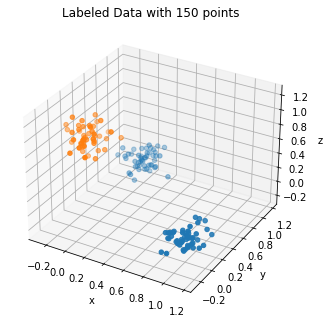

In [35]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

N_each = 50 # Number of points in each cluster
n_cluster = 3 # Number of clusters
N = N_each*n_cluster # Total number of points

mu, sigma = 0, 0.1 # mean and standard deviation
xs = np.random.normal(mu, sigma, N)
ys = np.random.normal(mu, sigma, N)
zs = np.random.normal(mu, sigma, N)

# Cluster centers: (1,0,0) (0,1,0) (0,0,1)
xs[:N_each] += 1; ys[N_each:2*N_each] += 1; zs[2*N_each:3*N_each] += 1
Data = np.array([xs,ys,zs]).T

u_dagger = np.append(np.ones(2*N_each), -1*np.ones(N_each))
Z_prime = np.array([0,50,100]) # Indices of labels
y = np.sign(u_dagger[Z_prime]) # One label is observed within each cluster

# Display plot
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(xs[:2*N_each], ys[:2*N_each], zs[:2*N_each], 'r')
ax.scatter(xs[2*N_each:3*N_each], ys[2*N_each:3*N_each], zs[2*N_each:3*N_each], 'b')
ax.set_title('Labeled Data with ' + str(N) +' points')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z');
plt.show()

In [36]:
# from time import perf_counter

# if __name__ == "__main__":
# # Initial Parameters
#     eps = 0.15
#     rval = 0.25 #threshold for kernel
#     tau = 1
#     alpha = 1
#     g = 0.5 #Noise standard deviation
#     n_eig = 20 #(62) truncation

#     time_start = perf_counter()
#     u_ast = u_ast_EL(Data, N, g, y, Z_prime, alpha, tau, eps, rval)
#     print("Runtime for EL: " + str(perf_counter() - time_start))
#     pred_error =  (sum(abs(np.sign(u_ast) - np.sign(u_dagger)))/(N)*100)
#     print("Error for EL: " + str(pred_error))


#     time_start = perf_counter()
#     u_ast_newt = u_ast_Newt(Data, N, g, y, Z_prime, alpha, tau, eps, rval)
#     print("Runtime for Newton's: " + str(perf_counter() - time_start))
#     pred_error =  (sum(abs(np.sign(u_ast_newt) - np.sign(u_dagger)))/(N)*100)
#     print("Error for Newton's: " + str(pred_error))

## Using Kernel Flow method 

autograd do not support vectorization of the code, so can't compute and treat W as a matrix

In [39]:
# Using Kernel Flow method to approximate parameters

# Return randomly selected half data indices from N that includes labeled data
# Follows from [1]
def select_Nf(N, Z_prime):
    '''
    N - (int) number of elements
    Z_prime - indices of labeled data
    '''
    N_f = int((N-Z_prime.size)/2) # Must be <= N

    # Randomly selected indices N_f and N_c used for X,Y,Z
    # Always need to include Z' or else cant compute
    N_f_i = np.random.choice(N, N_f, replace=False)
    for z in Z_prime:
        if z not in N_f_i:
            N_f_i = np.append(N_f_i, z)
    N_f = N_f_i.size
    return N_f_i

def theta_EL(X, N, Z_prime, y, theta_0, learning_rate, tol, maxiter):
    '''
    f - inputfunction
    theta_0 - initialization
    learning_rate - step size
    tol - tolerance for Gradient
    maxiter - maxmimum number of iterations
    '''
    # Follows rho expression given in [2]-(6)
#     def rho(theta):
#         '''
#         theta - parameters to optimize (g, alpha, tau, eps, rval)
#         X - whole data (not just half)
#         N - (int) number of elements
#         Z_prime - indices of labeled data
#         y - labels (of Z_prime)
#         '''
#         g, alpha, tau, eps, rval = theta
#         N_f_i = select_Nf(N, Z_prime)

#         uast = u_ast_EL(X, N, g, y, Z_prime, alpha, tau, eps, rval)
#         uast_tild = u_ast_EL(X, N_f_i, g, y, Z_prime, alpha, tau, eps, rval)

#         # Compute |uast-uast_tild|^2/|uast|^2 using L2 norm
#         # loop over each valid N_f_i
#         num = 0.0
#         denom = 0.0
#         for u_i, nf_i in enumerate(N_f_i):
#             num += (uast_tild[u_i] - uast[nf_i])**2
#             denom += uast[nf_i]**2
#         print("rho: " + str(num/denom))
#         return num/denom

    theta = theta_0
    # Testing rho function
    def rho(theta):
        '''
        theta - parameters to optimize (g, alpha, tau, eps, rval)
        X - whole data (not just half)
        N - (int) number of elements
        Z_prime - indices of labeled data
        y - labels (of Z_prime)
        '''
        g, alpha, tau, eps, rval  = theta
        N_f_i = select_Nf(N, Z_prime)
        uast = u_ast_EL(Data, np.arange(N), g, y, Z_prime, alpha, tau, eps, rval)
        uast_tild = u_ast_EL(Data, N_f_i, g, y, Z_prime, alpha, tau, eps, rval)

        # Compute |uast-uast_tild|^2/|uast|^2 using L2 norm
        # loop over each valid N_f_i
        num = 0.0
        denom = 0.0

        N_f = N_f_i.size
        u1 = np.zeros(N_f)
        u2 = np.zeros(N_f)
        diff = np.zeros(N_f)
        signdiff = 0.0

        for u_i, nf_i in enumerate(N_f_i):
            num += (uast_tild[u_i] - uast[nf_i])**2
            denom += uast[nf_i]**2

            u1[u_i] = uast_tild[u_i]
            u2[u_i] = uast[nf_i]
            diff[u_i] = (uast_tild[u_i] - uast[nf_i])**2
            signdiff += (np.sign(uast_tild[u_i]) != np.sign(uast[nf_i]))
        plt.scatter(N_f_i, u1, color = 'red')
        plt.scatter(N_f_i, u2, color = 'blue')
        plt.title("u_N*(blue) vs u_Nf*(red)")
        plt.show()
        plt.scatter(N_f_i, diff)
        plt.title("(u_N* - u_Nf*)^2")
        plt.show()
        print("sign diff: " + str(signdiff/N_f))

        print("rho: " + str(num/denom))

        return num/denom
    
    for it in range(maxiter):
        grad = autograd.elementwise_grad(rho)
        direction = grad(theta)
        theta = theta - learning_rate*direction
        print("direction: " + str(direction))
        if np.linalg.norm(direction) < tol:
            break
    return theta, it

In [40]:
# Testing rho function
def rho_test(theta):
        '''
        theta - parameters to optimize (g, alpha, tau, eps, rval)
        X - whole data (not just half)
        N - (int) number of elements
        Z_prime - indices of labeled data
        y - labels (of Z_prime)
        '''
        g, alpha, tau, eps, rval  = theta
        N_f_i = select_Nf(N, Z_prime)
        uast = u_ast_EL(Data, np.arange(N), g, y, Z_prime, alpha, tau, eps, rval)
        uast_tild = u_ast_EL(Data, N_f_i, g, y, Z_prime, alpha, tau, eps, rval)

        # Compute |uast-uast_tild|^2/|uast|^2 using L2 norm
        # loop over each valid N_f_i
        num = 0.0
        denom = 0.0

        N_f = N_f_i.size
        u1 = np.zeros(N_f)
        u2 = np.zeros(N_f)
        diff = np.zeros(N_f)
        signdiff = 0.0

        for u_i, nf_i in enumerate(N_f_i):
            num += (uast_tild[u_i] - uast[nf_i])**2
            denom += uast[nf_i]**2

            u1[u_i] = uast_tild[u_i]
            u2[u_i] = uast[nf_i]
            diff[u_i] = (uast_tild[u_i] - uast[nf_i])**2
            signdiff += (np.sign(uast_tild[u_i]) != np.sign(uast[nf_i]))
        plt.scatter(N_f_i, u1, color = 'red')
        plt.scatter(N_f_i, u2, color = 'blue')
        plt.title("u_N*(blue) vs u_Nf*(red)")
        plt.show()
        plt.scatter(N_f_i, diff)
        plt.title("(u_N* - u_Nf*)^2")
        plt.show()
        print("sign diff: " + str(signdiff/N_f))

        print("rho: " + str(num/denom))

        return num/denom

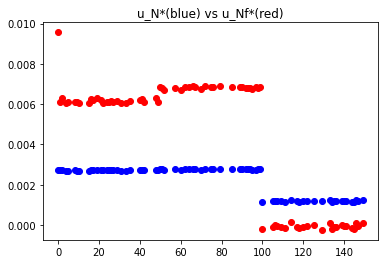

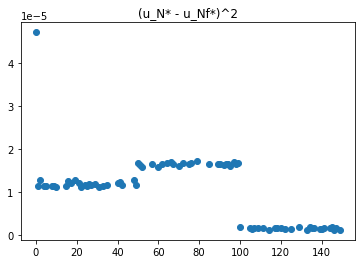

sign diff: 0.25
rho: 1.8984600647195327


1.8984600647195327

In [41]:
rho_test(np.array([1.5, 2, 2, 0.2, 1]))

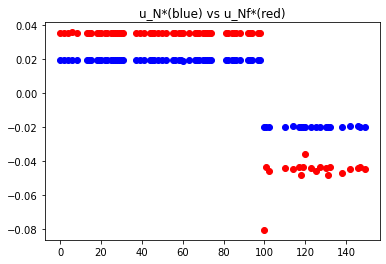

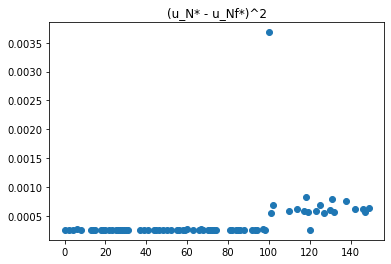

sign diff: 0.0
rho: 1.0321131896476279
direction: [0. 0. 0. 0. 0.]
Number of Iterations: 0
Theta: [0.5  1.   1.   0.15 0.25]


In [42]:
g = 0.5; alpha = 1; tau = 1; eps = 0.15; rval = 0.25
learning_rate = 1e-5; tol=1e-08; maxiter=100

theta_0 = np.array([g, alpha, tau, eps, rval])
theta, it = theta_EL(Data, N, Z_prime, y, theta_0, learning_rate, tol, maxiter)
print("Number of Iterations: " + str(it))
print("Theta: " + str(theta))